# Exercise 3: Importing and manipulating data

In the exercise, we're going to learn how to play with some tools for importing and maipulating data sets. We'll focus on a couple of key file types:

* Hierarchical Data Format 5 (HDF5): A format for saving large data sets in a "hierarchical" format like folders on your computer. In addition to storing the data itself in an efficient way, this format allows for metadata about the datasets to be embedded in the file itself. [HDF5 website](https://www.hdfgroup.org)
* Comma Seperated Value (CSV): Simply a spreadsheet stored as a text file.
* JavasSript Object Notation (JSON): A format for saving key value pairs (akin to a Python dictionary. [JSON website](https://www.json.org/)

Beyond talking about ways to open and access these files directly in python via the standard libraries and numpy, we'll also be talking about two really powerful tools for working with data in python:

* Pandas: a fast, powerful, flexible and easy to use open source data analysis and manipulation tool (reproduces much of the functionality of R). [Pandas website](https://pandas.pydata.org)
* Xarray:  an open source projectfor working with labelled multi-dimensional arrays. [Xarray website](http://xarray.pydata.org/en/stable/)

One great place to get data is 

* [Collaborative Research in Computational Neuroscience - Data repository](crcns.org): Great resource for published data sets. Need to request access but it is open.  

Good to practice with a complete data set _and_ see how other people store, organize, & archive their data.

## Really important stuff we probably won't have time for

* [Neurodata Without Borders (NWB)](https://www.nwb.org): 
* The [Allen Brain Observatory software development kit (allensdk)](https://allensdk.readthedocs.io/en/latest/install.html) has a lot of really powerful tools as well as access to their data. v

## Table of Contents 

* 3.1 HDF5 using `tables` 
    * 3.1.1 Loading HDF5 files
    * 3.1.2 Navigating HDF5 files
    * 3.1.3 Writing to HDF5 files
* 3.2 JSON 
* 3.3 `pandas`
    * 3.4.1 Loading CSV files
    * ...
* 3.4 `xarray`
    * ...
* 3.5 Neurodata without borders file format (NWB:N) and python API `pynwb`
    

In [103]:
import numpy as np

## 3.1 HDF5 using `tables` 

The `pytables` package is a  robust way to interact with HDF5 files. [You can find the package website here](https://www.pytables.org).  `h5py` is another well maintained package. 

In [113]:
import tables

### 3.1.1 Loading HDF5 files

In [89]:
# importing the HDF5 file into python as `data`.
# The 'r' here stands for 'read'. Could have just as easily been 'w' for write or 'a' for append. 

data = tables.File("data/dataset_2017_08_25_postrun/2017-08-25_09-50-43.hdf5", 'r')

In [96]:
# To have tables spit out the whole kit and caboodle  

data

File(filename=data/dataset_2017_08_25_postrun/2017-08-25_09-50-43.hdf5, title='', mode='r', root_uep='/', filters=Filters(complevel=0, shuffle=False, bitshuffle=False, fletcher32=False, least_significant_digit=None))
/ (RootGroup) ''
/behavior (Group) ''
/behavior/linear_position (Array(30163,)) ''
  atom := Float64Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := None
/behavior/linearization_matrix (Array(720, 576)) ''
  atom := Float64Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := None
/behavior/speed (Array(30163,)) ''
  atom := Float64Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := None
/behavior/time (Array(30163,)) ''
  atom := Float64Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := None
/ephys (Group) ''
/general (Group) ''
/general/start_time (Array(1,)) ''
  atom := Float64A

### 3.1.2 Navigating HDF5 files

In [ ]:
data.root.?

In [104]:
spikes = data.root.ephys.TT1.spikes.times

TypeError: ufunc 'sqrt' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

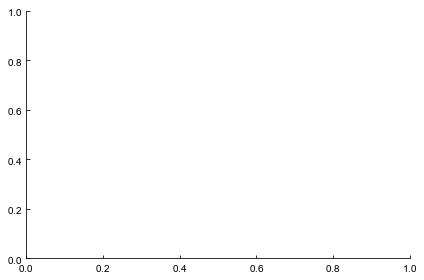

In [110]:
plt.scatter(spikes[:100], 100*[1], s='|')

### 3.1.3 Writing to HD5 files

In [142]:
h5file = tables.open_file("data/my_data.h5", mode="a", title="My test file")

In [143]:
# Creating a group

group = h5file.create_group("/", 'cell_1', 'Data from cell_1')

In [144]:
# Making some fake data 

time = np.linspace(0, 100, 1000)
voltage = np.random.rand(1000)

In [145]:
# saving these as arrays in the hdf5 file

h5file.create_array(group, 'time', time, "time (ms)")
h5file.create_array(group, 'voltage', voltage, "voltage (mV)")

/cell_1/voltage (Array(1000,)) 'voltage (mV)'
  atom := Float64Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := None

In [147]:
h5file

File(filename=data/my_data.h5, title='My test file', mode='a', root_uep='/', filters=Filters(complevel=0, shuffle=False, bitshuffle=False, fletcher32=False, least_significant_digit=None))
/ (RootGroup) 'My test file'
/cell_1 (Group) 'Data from cell_1'
/cell_1/time (Array(1000,)) 'time (ms)'
  atom := Float64Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := None
/cell_1/voltage (Array(1000,)) 'voltage (mV)'
  atom := Float64Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := None

In [148]:
# Can also create tables with columns of different types
# Definiing the information you'd like in your table, and creating an empty table

class my_ephys(tables.IsDescription):
    time  = tables.Float32Col()      # Signed 64-bit integ
    voltage = tables.Float32Col()
    
table = h5file.create_table(group, 'my_data', my_ephys, "recording session")

In [149]:
moment = table.row
for i, j in zip(time, voltage):
    moment['time']  = i
    moment['voltage'] = j
    moment.append()

table.flush()

In [150]:
h5file

File(filename=data/my_data.h5, title='My test file', mode='a', root_uep='/', filters=Filters(complevel=0, shuffle=False, bitshuffle=False, fletcher32=False, least_significant_digit=None))
/ (RootGroup) 'My test file'
/cell_1 (Group) 'Data from cell_1'
/cell_1/my_data (Table(1000,)) 'recording session'
  description := {
  "time": Float32Col(shape=(), dflt=0.0, pos=0),
  "voltage": Float32Col(shape=(), dflt=0.0, pos=1)}
  byteorder := 'little'
  chunkshape := (8192,)
/cell_1/time (Array(1000,)) 'time (ms)'
  atom := Float64Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := None
/cell_1/voltage (Array(1000,)) 'voltage (mV)'
  atom := Float64Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := None

In [ ]:
# Saving metadata





## 3.3 `pandas`

We're going to be working through [the `pandas` tutorials here.](https://pandas.pydata.org/pandas-docs/stable/getting_started/intro_tutorials/index.html)

In [152]:
import pandas as pd

### 3.3.1 Creating a `DataFrame` object 

### 3.3.2 Selecting subsets of data

### 3.3.3 Importing data from a CSV file

### 3.3.4 Creating new columns from old columns

## 3.4 xarray

Very often arrays are objects that have coordinates associated with each of the dimesions (like time or space), but numpy doesn't have a method for storing those coordinates with the arrays. This can get cumbersome and basic operations (like interpolating between two coordinates) becomes more difficult than you would want. `xarray` is a package designed to address these deficiencies in `numpy`. Two main obects `DataArray` and a `DataSet`. 

In [151]:
import xarray as xa

### 3.4.1 Constructing a `DataArray`

### 3.4.2 Accessing data array elements

### 3.4.3 Interpolating 

### 3.4.4 Loading / saving xarray objects

## 3.5 NeuroData without Borders



In [2]:
from pynwb import NWBHDF5IO